In [1]:
import math
import json
import numpy as np
from collections import Counter

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import plotly.graph_objects as go

from tqdm import tqdm

from nano_bert.tokenizer import WordTokenizer
from nano_bert.dataload_imdb import encode_label, IMDBDataloader, mask_text, spit_cmt, nsp_gen, plot_results

from nano_bert.model import BertMix3
model = 'BERT'
torch.manual_seed(114514)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data = None
with open('data/imdb_train.json') as f:
    data = [json.loads(l) for l in f.readlines()]

In [3]:
test_data = None
with open('data/imdb_test.json') as f:
    test_data = [json.loads(l) for l in f.readlines()]

In [4]:
rawvocab = [] # whole vocab
for d in tqdm(data): 
    rawvocab.append([w.lower() for w in d['text']]) # symbol like '.' is remained
vocab = set() # vocab for words appear more than 2 times(minappear = 2)
minappear = 2
for v in tqdm(rawvocab):
    if rawvocab.count(v) > minappear - 1:
        vocab |= set(v)

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:06<00:00, 4155.20it/s]


In [5]:
NUM_CLASS = 2
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
LEARNING_RATE = 1e-4

In [6]:
vocab.discard('.') # '.' is included in taken's vocab enumerate
tokenizer = WordTokenizer(vocab=vocab, max_seq_len=MAX_SEQ_LEN)
tokenizer

Tokenizer[vocab=3665,self.special_tokens=['[MSK]', '[PAD]', '[CLS]', '[SEP]', '[UNK]', '[SOS]', '.'],self.sep=' ',self.max_seq_len=128]

In [7]:
dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE)

Val Label Encoding: 100%|██████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 836652.04it/s]


In [40]:
bert = BertMix3(
    vocab_size=len(tokenizer.vocab),
    n_layers=3,
    n_heads=1,
    max_seq_len=MAX_SEQ_LEN,
    n_classes=NUM_CLASS,
    n_embed = 4
).to(device)
bert

BertMix3(
  (nano_bert): NanoBERT(
    (embedding): BertEmbeddings(
      (word_embeddings): Embedding(3665, 4)
    )
    (position): PositionalEncoding(
      (layer_norm): LayerNorm((4,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0-2): 3 x BertLayer(
          (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (self_attention): BertSelfAttention(
            (heads): ModuleList(
              (0): BertAttentionHead(
                (query): Linear(in_features=4, out_features=4, bias=True)
                (key): Linear(in_features=4, out_features=4, bias=True)
                (values): Linear(in_features=4, out_features=4, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (proj): Linear(in_features=4, out_features=4, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
count_parameters(bert)

29628

In [17]:
dataloader.steps('train')
dataloader.get_split('train')

In [18]:
history_pretrain = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}
history = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

### pretrain task, 25 min/epoch

In [13]:
optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 15 # epochs for pretrain task
vacab_size = len(tokenizer.vocab)
n_sp = len(tokenizer.special_tokens)
for i in range(NUM_EPOCHS):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0

    bert.train()
    for step, batch in enumerate(tqdm(dataloader.get_split('train'), total=dataloader.steps('train'), position=0)):
        loss = 0
        cudata = batch['input_ids'].to(device) # put the dat in the whole batch to gpu
        # MLM part
        for i in range(len(cudata)): # BATCH_SIZE = len(cudata)
            mps, mcmt = mask_text(cudata[i], vacab_size, MAX_SEQ_LEN, n_sp)
            lmps = len(mps)
            _, r_mlm, _ = bert(mcmt.unsqueeze(dim=0)) # (Batch, Seq_Len, len(vocab))
            MCMT = r_mlm[0][mps, :] # fectch the predicted value from masked input
            predm = cudata[i][mps].long() # fectch the real word correspond to the masked input
            for i in range(lmps):
                loss += F.cross_entropy(MCMT.to(device), predm.to(device)) / lmps
        
        # NSP part
        for i in range(len(cudata)): 
            spit, n_st = spit_cmt(cudata[i]) # (Batch, Seq_Len, len(vocab)), number of sentences
            if n_st > 1: # calculate NSP loss if a comment has more than 1 sentence
                predn = torch.tensor([1, 0] * (n_st - 1)).to(device) # label of next/not next composed sentences
                if n_st < 3:
                    predn = torch.tensor([1]).to(device)
                _, _, r_nsp = bert(nsp_gen(spit, n_st, MAX_SEQ_LEN))
#                 print(n_st)
#                 print(r_nsp[:, 0, :].shape, predn.shape)
#                 print(r_nsp[:, 0, :], predn)
                loss +=  F.cross_entropy(r_nsp[:, 0, :], predn)
#         print('train_loss:', '%.2f'%loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
    history_pretrain['train_losses'].append(train_loss / dataloader.steps("train"))
    print('train_loss:', '%.2f'%history_pretrain['train_losses'][-1])
    val_loss = 0.0

D:\Anaconda3\envs\311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1


  8%|██████▎                                                                          | 49/625 [03:11<37:29,  3.91s/it]


KeyboardInterrupt: 

In [ ]:
PATH = 'para/'+ model + '_imdb_pre_para.pth'# parameter for pretrain task
torch.save(bert.state_dict(), PATH)

### Fine-tuning on text classification downstream task, 20s/epoch

In [24]:
BATCH_SIZE_F = 32
dataloader_F = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE_F)

Val Label Encoding: 100%|█████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1003518.04it/s]


In [25]:
NUM_EPOCHS_F = 200
#optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)
for i in range(NUM_EPOCHS_F):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0
    train_preds = []
    train_labels = []

    bert.train()
    for step, batch in enumerate(tqdm(dataloader_F.get_split('train'), total=dataloader_F.steps('train'), position=0)):
        r_cls, _, _ = bert(batch['input_ids'].to(device)) # (B, Seq_Len, 2)

        probs = F.softmax(r_cls[:, 0, :], dim=-1).cpu()# fetch the result from the first word in the text as output
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(r_cls[:, 0, :].cpu(), batch['label_ids'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    val_preds = []
    val_labels = []

    bert.eval()
    for step, batch in enumerate(tqdm(dataloader.get_split('val'), total=dataloader.steps('val'), position=0)):
        r_cls, _, _ = bert(batch['input_ids'].to(device))

        probs = F.softmax(r_cls[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        val_preds += pred.detach().tolist()
        val_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(r_cls[:, 0, :].cpu(), batch['label_ids'])

        val_loss += loss.item()

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)
    history['train_acc'].append(accuracy_score(train_labels, train_preds))
    history['val_acc'].append(accuracy_score(val_labels, val_preds))
    history['train_f1'].append(f1_score(train_labels, train_preds))
    history['val_f1'].append(f1_score(val_labels, val_preds))

    print()
    print(f'Train loss: {train_loss / dataloader.steps("train")} | Val loss: {val_loss / dataloader.steps("val")}')
    print(f'Train acc: {accuracy_score(train_labels, train_preds)} | Val acc: {accuracy_score(val_labels, val_preds)}')
    print(f'Train f1: {f1_score(train_labels, train_preds)} | Val f1: {f1_score(val_labels, val_preds)}')

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:29<00:00, 21.16it/s]
157it [00:03, 42.96it/s]                                                                                               



Train loss: 0.7046246669769287 | Val loss: 0.7080370951921512
Train acc: 0.49915 | Val acc: 0.4988
Train f1: 0.2184598580010923 | Val f1: 0.21343377275580666
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:29<00:00, 20.93it/s]
157it [00:03, 43.33it/s]                                                                                               



Train loss: 0.7044191128730773 | Val loss: 0.7080370951921512
Train acc: 0.4969 | Val acc: 0.4988
Train f1: 0.20721714465805233 | Val f1: 0.21343377275580666
Epoch: 3


  4%|██▊                                                                              | 22/625 [00:01<00:30, 20.08it/s]


KeyboardInterrupt: 

In [26]:
PATH = 'para/'+ model + 'imdb_tcl_para_BERT.pth'# parameter for text classification
torch.save(bert.state_dict(), PATH)

C:\Users\HASEE\AppData\Local\Temp\ipykernel_8832\3888044536.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


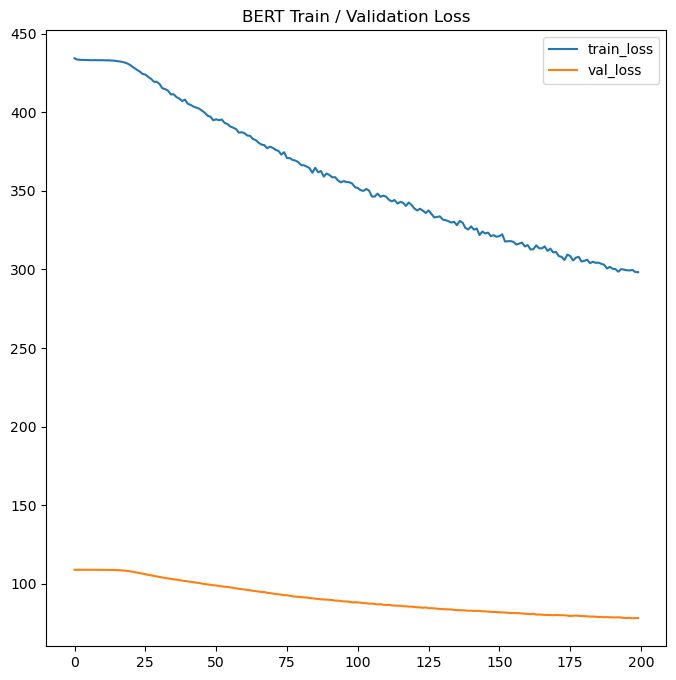

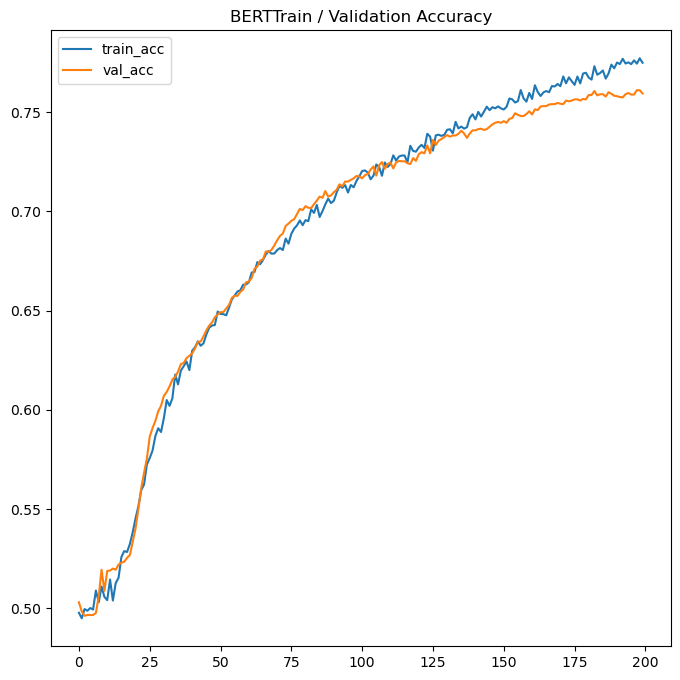

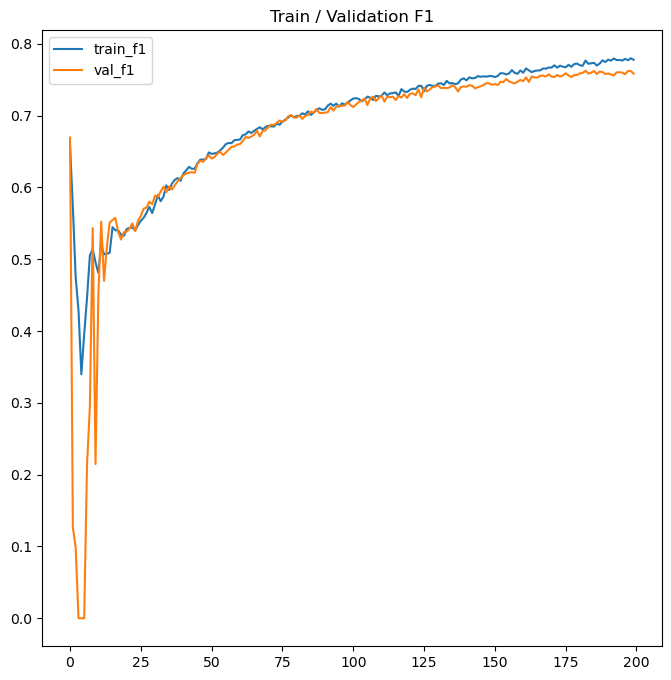

In [41]:
plot_results(history, model)

In [ ]:
logits[0]

In [ ]:
test_loss = 0.0
test_preds = []
test_labels = []

bert.eval()
for step, batch in enumerate(tqdm(dataloader.get_split('test'), total=dataloader.steps('test'))):
    logits = bert(batch['input_ids'].to(device))[0]

    probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1) # (B)
    test_preds += pred.detach().tolist()
    test_labels += [l.item() for l in batch['label_ids']]

    loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

    test_loss += loss.item()

print()
print(f'Test loss: {test_loss / dataloader.steps("test")}')
print(f'Test acc: {accuracy_score(test_labels, test_preds)}')
print(f'Test f1: {f1_score(test_labels, test_preds)}')

# Interpreting and visualizing the results

In [ ]:
def get_attention_scores(model, input_ids):
    """
    This is just a wrapper to easily access attention heads of the last layer
    """

    mask = (input_ids > 0).unsqueeze(1).repeat(1, input_ids.size(1), 1)

    embed = model.nano_bert.embedding(input_ids)

    # can be any layer, and we can also control what to do with output for each layer (aggregate, sum etc.)
    layer = model.nano_bert.encoder.layers[-1]

    x = layer.layer_norm1(embed)

    B, seq_len, n_embed = x.shape

    # if have more than 1 head, or interested in more than 1 head output just add aggregation here
    head = layer.self_attention.heads[0]

    # this is just a part of the single head that does all the computations (same code is present in AttentionHead)
    q = head.query(x)
    k = head.key(x)
    v = head.values(x)

    weights = (q @ k.transpose(-2, -1)) / math.sqrt(n_embed)  # (B, Seq_len, Seq_len)
    weights = weights.masked_fill(mask == 0, -1e9)  # mask out not attended tokens

    scores = F.softmax(weights, dim=-1)

    return scores

In [ ]:
test_dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=1)

In [ ]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the A and B
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    plt.title(f'Attention scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

In [ ]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(test_dataloader.splits['test']):
    if len(v) <= 16:
        examples_ids.append(i)
print(examples_ids)

In [ ]:
tokens

In [ ]:
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if (t != 0 and t.item() != 1)], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    # calculate attention scores
    att_matrix = get_attention_scores(bert, test_tokenized_batch['input_ids'].to(device))[0, :seq_len, :seq_len]

    plot_parallel(att_matrix, tokens=tokens)